# Testing Embedding techniques for Clustering

## Import dependencies

In [27]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import warnings # ignore warnings
warnings.filterwarnings('ignore')

## Import dataset

In [2]:
df = pd.read_csv('../data/customers_100k.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   country_name                     100000 non-null  object 
 2   account_category                 100000 non-null  object 
 3   bi_account_classification        100000 non-null  object 
 4   customer_type                    100000 non-null  object 
 5   region                           100000 non-null  object 
 6   sic_code                         100000 non-null  int64  
 7   employee_number                  100000 non-null  int64  
 8   revenue_in_eur                   100000 non-null  float64
 9   number_distinct_active_licenses  100000 non-null  int64  
 10  major_edition                    100000 non-null  object 
 11  total_connections_12m            100000 non-null  int64  
 12  tot

In [4]:
# Drop unecessary columns
df.drop(columns=['country_name', 'last_invoice_date_created', 'business_model'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   account_category                 100000 non-null  object 
 2   bi_account_classification        100000 non-null  object 
 3   customer_type                    100000 non-null  object 
 4   region                           100000 non-null  object 
 5   sic_code                         100000 non-null  int64  
 6   employee_number                  100000 non-null  int64  
 7   revenue_in_eur                   100000 non-null  float64
 8   number_distinct_active_licenses  100000 non-null  int64  
 9   major_edition                    100000 non-null  object 
 10  total_connections_12m            100000 non-null  int64  
 11  total_endpoints_12m              100000 non-null  int64  
 12  tot

In [6]:
df.head(5)

,account_id,account_category,bi_account_classification,customer_type,region,sic_code,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated
0,ac6a99474410f1c59c91da3f0cf9cf3f,Standard,Inside Sales,Customer,APAC,7381,8,1502000.0,1,Business,54,4,2,Webshop,6,5,2532.84,466.47
1,1cc66628ed41f3db5a55195e93277a04,Standard,Inside Sales,Customer,AMERICAS,5049,11,1814000.0,1,Premium,3385,158,51,Webshop,1,0,1298.15,972.57
2,db5f3cdd5629b9591b720b9b7e077df2,Standard,Inside Sales,Customer,AMERICAS,7389,16,13444000.0,1,Remote Access,12,2,2,Webshop,2,1,155.83,76.69
3,bebb4028688f519f36ed220855b0a62f,Standard,Reseller,End-User Reseller,AMERICAS,8711,36,7066000.0,3,Corporate,1724,206,30,Inside Sales,7,5,7550.16,1088.58
4,507c0bfb67895d773e3f8bd33b861d09,Standard,Inside Sales,Customer,AMERICAS,6531,312,61054000.0,2,Corporate,6493,611,31,Inside Sales,10,1,4688.33,1593.70


In [7]:
# Exclude the 'id' column
cols = df.columns.difference(['account_id'])

# Create the 'array' column using numpy
# df['array'] = df[cols].to_numpy().tolist()

# Create a new column 'text_like_column' by concatenating values of selected columns
df['DNA'] = df[cols].apply(lambda row: ' '.join(map(str, row)), axis=1)

In [8]:
df.DNA[0]

'Standard 2532.84 6 Inside Sales 466.47 Webshop Customer 8 Business 1 5 APAC 1502000.0 7381 54 2 4'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   account_category                 100000 non-null  object 
 2   bi_account_classification        100000 non-null  object 
 3   customer_type                    100000 non-null  object 
 4   region                           100000 non-null  object 
 5   sic_code                         100000 non-null  int64  
 6   employee_number                  100000 non-null  int64  
 7   revenue_in_eur                   100000 non-null  float64
 8   number_distinct_active_licenses  100000 non-null  int64  
 9   major_edition                    100000 non-null  object 
 10  total_connections_12m            100000 non-null  int64  
 11  total_endpoints_12m              100000 non-null  int64  
 12  tot

In [10]:
df = df[['account_id', 'DNA']]
df

,account_id,DNA
0,ac6a99474410f1c59c91da3f0cf9cf3f,Standard 2532.84 6 Inside Sales 466.47 Webshop...
1,1cc66628ed41f3db5a55195e93277a04,Standard 1298.15 1 Inside Sales 972.57 Webshop...
2,db5f3cdd5629b9591b720b9b7e077df2,Standard 155.83 2 Inside Sales 76.69 Webshop C...
3,bebb4028688f519f36ed220855b0a62f,Standard 7550.16 7 Reseller 1088.58 Inside Sal...
4,507c0bfb67895d773e3f8bd33b861d09,Standard 4688.33 10 Inside Sales 1593.7 Inside...
...,...,...
99995,7396a9c9504211ce55073ace6c8d4913,Standard 4390.97 4 Inside Sales 1111.1 Webshop...
99996,8d680e3cfa74cc08e8268254e99e1f48,Standard 11593.84 10 Inside Sales 1522.02 Insi...
99997,6449e4ad632b62eae4f4f7708d257a9e,Standard 2205.64 4 Inside Sales 571.51 Webshop...
99998,973778c47a7242c7e150f5ac7172dc10,Standard 163.36 2 Inside Sales 78.7 Webshop Cu...


### Embeddings

In [11]:
corpus = list(df['DNA'])
corpus = corpus[0:10000]

In [12]:
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [13]:
corpus_embeddings = embedder.encode(corpus)

In [18]:
corpus_embeddings.shape[1]

768

In [45]:
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [46]:
cluster_df = pd.DataFrame(corpus, columns= ['corpus'])
cluster_df['cluster'] = cluster_assignment
cluster_df.head(10)

,corpus,cluster
0,Standard 2532.84 6 Inside Sales 466.47 Webshop...,1
1,Standard 1298.15 1 Inside Sales 972.57 Webshop...,1
2,Standard 155.83 2 Inside Sales 76.69 Webshop C...,1
3,Standard 7550.16 7 Reseller 1088.58 Inside Sal...,1
4,Standard 4688.33 10 Inside Sales 1593.7 Inside...,2
5,Standard 971.96 5 Inside Sales 198.63 Webshop ...,1
6,Standard 66581.67 7 Reseller 837.31 Reseller R...,0
7,Standard 2986.48 12 Inside Sales 211.88 Other ...,1
8,SMB 46022.86 9 Inside Sales 9129.48 Inside Sal...,2
9,Standard 12584.99 15 Inside Sales 1308.89 Insi...,2


In [47]:
# Assuming embeddings are 2D or using PCA to reduce to 2D for visualization
if corpus_embeddings.shape[1] > 2:
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(corpus_embeddings)
else:
    reduced_embeddings = corpus_embeddings

In [48]:
embedding_df = pd.DataFrame(reduced_embeddings, columns=['Dim1', 'Dim2'])
embedding_df['Cluster'] = cluster_assignment

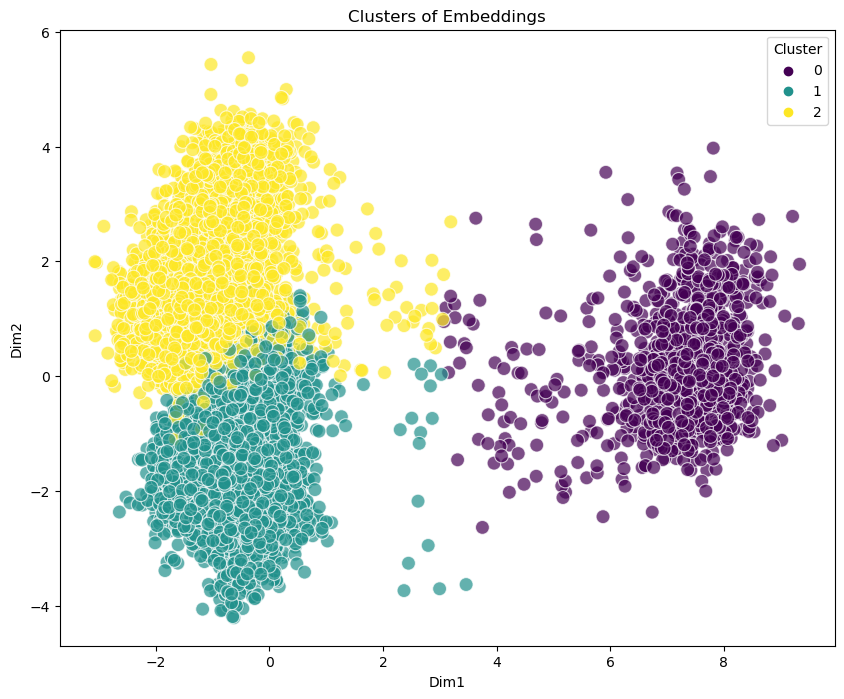

In [49]:
# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=embedding_df, x='Dim1', y='Dim2', hue='Cluster', palette='viridis', s=100, alpha=0.7)
plt.title('Clusters of Embeddings')
plt.show()

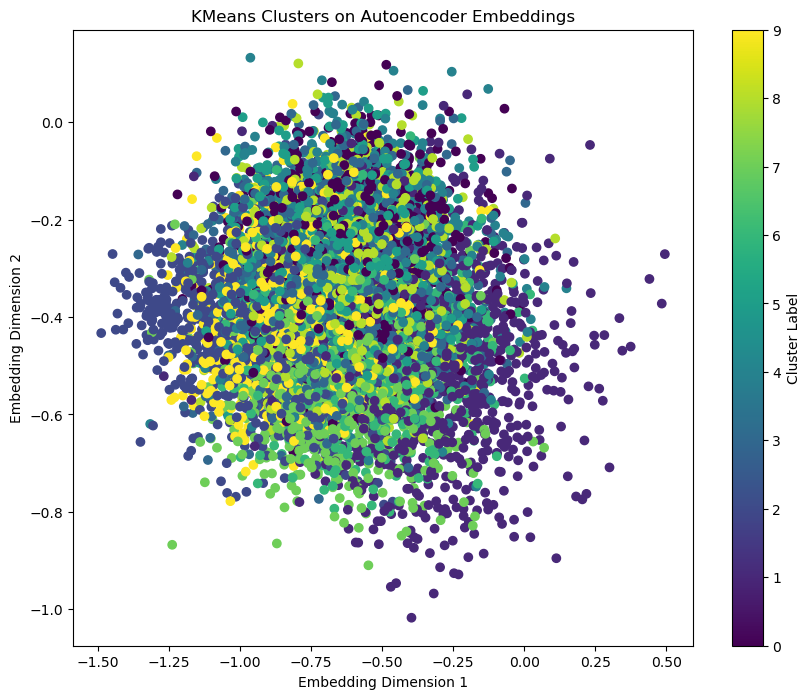

In [85]:
plt.figure(figsize=(10, 8))
plt.scatter(corpus_embeddings[:, 0], corpus_embeddings[:, 1], c=cluster_assignment, cmap='viridis', marker='o')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('KMeans Clusters on Autoencoder Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()

In [84]:
clustered_DNA = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_DNA[cluster_id].append(corpus[sentence_id])
    
for i, cluster in enumerate(clustered_DNA):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['SMB 46022.86 9 Inside Sales 9129.48 Inside Sales Customer 5 Corporate 3 4 AMERICAS 934000.0 8111 22037 1311 3766', 'Standard 4313.73 2 Inside Sales 1557.5 Inside Sales Customer 25 Corporate 1 1 EMEA 2541000.0 8711 14338 27 1754', 'Standard 2367.88 9 Inside Sales 279.3 Inside Sales Customer 1 Business 3 5 EMEA 105384.0 5961 3881 6 298', 'Standard 13634.27 11 Inside Sales 1855.44 Inside Sales Customer 9 Tensor 3 3 APAC 1840000.0 7372 9607 35 351', 'Standard 3634.75 8 Inside Sales 849.26 Inside Sales Customer 28 Corporate 5 3 APAC 5434000.0 7373 8425 14 2533', 'Standard 3718.76 9 Inside Sales 520.87 Inside Sales Customer 277 Corporate 2 2 APAC 69162000.0 6411 430 9 85', 'Standard 1652.6 3 Inside Sales 329.216666666667 Other Customer 19 Business 1 1 APAC 3687000.0 7532 73 1 6', 'Standard 1112.4 3 Inside Sales 394.8 Inside Sales Customer 2 Business 1 2 EMEA 214131.0 5999 8180 8 210', 'Standard 1008.29 7 Inside Sales 381.88 Inside Sales Customer 73 Business 3 4 EMEA 5924872.0 20